In [2]:
# 1. Instalação de dependências
!pip install -q tslearn scikit-learn umap-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import umap
from tslearn.datasets import UCR_UEA_datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [4]:
# 3. Carregamento e Pré-processamento
ucr = UCR_UEA_datasets()
X, y, _, _ = ucr.load_dataset("ECG5000")

In [5]:
# Normalização
X = X.reshape((X.shape[0], X.shape[1]))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Separação
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.9, random_state=42, stratify=y)

In [7]:
# 4. Dataset personalizado
class ECGDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return (self.data[idx], self.labels[idx]) if self.labels is not None else self.data[idx]

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

In [8]:
# 5. Backbone CNN-1D simples
class CNN1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, 5, padding=2), nn.ReLU(),
            nn.Conv1d(32, 64, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

    def forward(self, x):
        return self.encoder(x).squeeze(-1)


In [9]:
# 6. Tarefa SimCLR com múltiplas transformadas
class RandomTransform:
    def __init__(self, sigma_jitter=0.03, sigma_scaling=0.1, max_shift=10, max_mask_size=10):
        self.sigma_jitter = sigma_jitter
        self.sigma_scaling = sigma_scaling
        self.max_shift = max_shift
        self.max_mask_size = max_mask_size

    def __call__(self, x):
        # Aplica jitter com probabilidade 80%
        if torch.rand(1) < 0.8:
            x = x + torch.randn_like(x) * self.sigma_jitter

        # Aplica scaling com probabilidade 80%
        if torch.rand(1) < 0.8:
            scaling_factor = torch.randn((x.size(0), 1, 1), device=x.device) * self.sigma_scaling + 1
            x = x * scaling_factor

        # Aplica shift com probabilidade 50%
        if torch.rand(1) < 0.5:
            shifts = torch.randint(-self.max_shift, self.max_shift+1, (x.size(0),), device=x.device)
            for i in range(x.size(0)):
                x[i] = torch.roll(x[i], shifts[i].item(), dims=-1)

        # Aplica masking com probabilidade 30%
        if torch.rand(1) < 0.3:
            mask = torch.ones_like(x)
            for i in range(x.size(0)):
                if x.size(2) > self.max_mask_size:
                    mask_start = torch.randint(0, x.size(2) - self.max_mask_size, (1,)).item()
                else:
                    mask_start = 0
                mask_size = torch.randint(1, self.max_mask_size + 1, (1,)).item()
                mask[i, :, mask_start:mask_start+mask_size] = 0
            x = x * mask

        return x

def simclr_loss(z1, z2, temperature=0.5):
    z1 = nn.functional.normalize(z1, dim=1)
    z2 = nn.functional.normalize(z2, dim=1)
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = torch.matmul(representations, representations.T)
    labels = torch.arange(z1.shape[0])
    labels = torch.cat([labels, labels], dim=0).to(z1.device)

    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(z1.device)
    logits = similarity_matrix[~mask].view(labels.shape[0], -1) / temperature

    positives = torch.sum(z1 * z2, dim=-1).repeat(2)
    loss = -torch.log(torch.exp(positives / temperature) / torch.sum(torch.exp(logits), dim=-1))
    return loss.mean()

In [10]:
# 7. Treinamento SSL SimCLR
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN1D().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
transform = RandomTransform()

for epoch in range(100):
    model.train()
    total_loss = 0
    for batch in loader:
        x, _ = batch
        x = x.to(device)
        x1 = transform(x)
        x2 = transform(x)
        z1 = model(x1)
        z2 = model(x2)
        loss = simclr_loss(z1, z2)
        optimizer.zero_grad()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

Epoch 1, Loss: 4.5348
Epoch 2, Loss: 4.5336
Epoch 3, Loss: 4.5344
Epoch 4, Loss: 4.5389
Epoch 5, Loss: 4.5361
Epoch 6, Loss: 4.5360
Epoch 7, Loss: 4.5347
Epoch 8, Loss: 4.5349
Epoch 9, Loss: 4.5352
Epoch 10, Loss: 4.5351
Epoch 11, Loss: 4.5339
Epoch 12, Loss: 4.5350
Epoch 13, Loss: 4.5352
Epoch 14, Loss: 4.5332
Epoch 15, Loss: 4.5342
Epoch 16, Loss: 4.5356
Epoch 17, Loss: 4.5339
Epoch 18, Loss: 4.5349
Epoch 19, Loss: 4.5341
Epoch 20, Loss: 4.5374
Epoch 21, Loss: 4.5354
Epoch 22, Loss: 4.5334
Epoch 23, Loss: 4.5390
Epoch 24, Loss: 4.5367
Epoch 25, Loss: 4.5339
Epoch 26, Loss: 4.5372
Epoch 27, Loss: 4.5348
Epoch 28, Loss: 4.5382
Epoch 29, Loss: 4.5342
Epoch 30, Loss: 4.5347
Epoch 31, Loss: 4.5356
Epoch 32, Loss: 4.5355
Epoch 33, Loss: 4.5355
Epoch 34, Loss: 4.5370
Epoch 35, Loss: 4.5343
Epoch 36, Loss: 4.5328
Epoch 37, Loss: 4.5344
Epoch 38, Loss: 4.5361
Epoch 39, Loss: 4.5352
Epoch 40, Loss: 4.5369
Epoch 41, Loss: 4.5347
Epoch 42, Loss: 4.5349
Epoch 43, Loss: 4.5343
Epoch 44, Loss: 4.53

In [11]:
# 8. Extração de embeddings
def extract_embeddings(model, dataset):
    loader = DataLoader(dataset, batch_size=64)
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            x, y = batch
            x = x.to(device)
            z = model(x)
            embeddings.append(z.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(embeddings), np.concatenate(labels)

emb_train, y_train = extract_embeddings(model, train_dataset)
emb_test, y_test = extract_embeddings(model, test_dataset)

In [12]:
# 9. Classificação Linear Probe
clf = LogisticRegression(max_iter=1000).fit(emb_train, y_train)
y_pred = clf.predict(emb_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score (macro):", f1_score(y_test, y_pred, average="macro"))

Accuracy: 0.6733333333333333
F1 Score (macro): 0.2546935960716954


In [13]:
# 10. k-NN no espaço latente
knn = KNeighborsClassifier(n_neighbors=5).fit(emb_train, y_train)
y_knn = knn.predict(emb_test)
print("k-NN Accuracy (no rótulo supervisionado):", accuracy_score(y_test, y_knn))

k-NN Accuracy (no rótulo supervisionado): 0.8311111111111111


In [14]:
# 11. Métrica de Silhouette
silhouette = silhouette_score(emb_test, y_test)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.13384447


In [15]:
# 12. Visualização com t-SNE
def plot_projection(embeddings, labels, title="t-SNE"):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=embeddings[:,0], y=embeddings[:,1], hue=labels, palette="tab10", s=30)
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

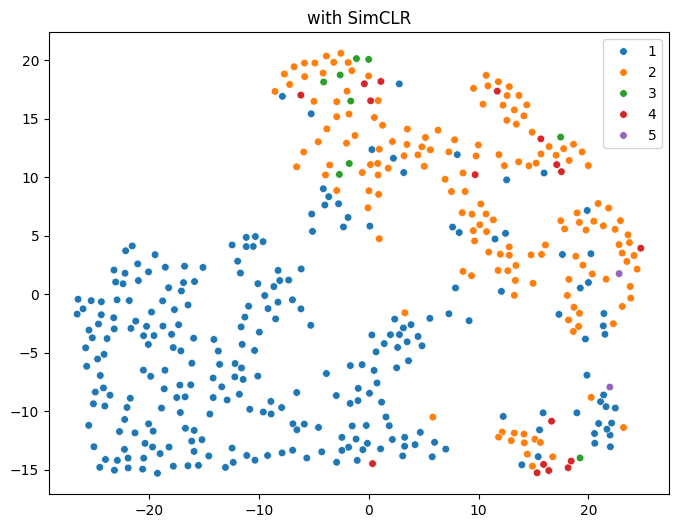

In [16]:
# t-SNE
tsne_proj = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(emb_test)
plot_projection(tsne_proj, y_test, title="with SimCLR")